### TEAM MEMBERS
* * *
- *Rajan Ghimire*
  - Student id : C0924991

- *Aarjeyan Shrestha*
  - Student id : C0927422

In [ ]:
import torch
import torchvision

In [ ]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
train_dataset = torchvision.datasets.MNIST(
    "data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,)),
        ]
    ),
)

test_dataset = torchvision.datasets.MNIST(
    "data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,)),
        ]
    ),
)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from copy import deepcopy

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:



subset_size = 1000
indices = torch.randperm(len(train_dataset))[:subset_size]
train_subset = torch.utils.data.Subset(train_dataset, indices)

batch_loader = torch.utils.data.DataLoader(train_subset, batch_size=len(train_dataset))
minibatch_loader = torch.utils.data.DataLoader(train_subset, batch_size=32)
sgd_loader = torch.utils.data.DataLoader(train_subset, batch_size=1)

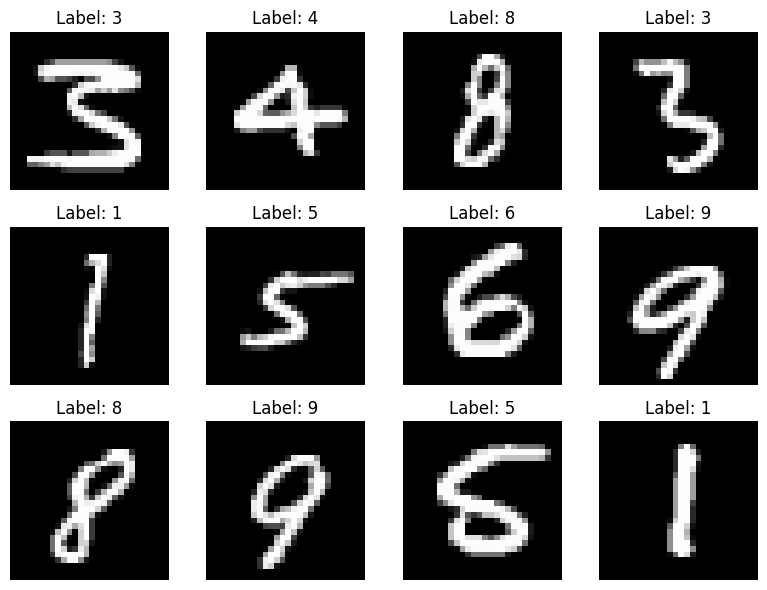

In [ ]:
examples = enumerate(minibatch_loader)
batch_idx, (images, labels) = next(examples)

fig, axes = plt.subplots(3, 4, figsize=(8, 6))

for i, ax in enumerate(axes.flat):
    img = images[i].squeeze().numpy()
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
def train(model, optimizer, train_loader, epochs, batch_size, optimizer_name):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            if optimizer_name == 'batch' and i > 0:
                break

            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / (i + 1)
        losses.append(epoch_loss)

        if epoch % 5 == 0:
            print(f'{optimizer_name} - Epoch {epoch}: Loss = {epoch_loss:.4f}')

    return losses



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_model = Net().to(device)
minibatch_model = deepcopy(batch_model)
sgd_model = deepcopy(batch_model)

batch_optimizer = optim.SGD(batch_model.parameters(), lr=0.01)
minibatch_optimizer = optim.SGD(minibatch_model.parameters(), lr=0.01)
sgd_optimizer = optim.SGD(sgd_model.parameters(), lr=0.01)

epochs = 20
batch_losses = train(batch_model, batch_optimizer, batch_loader, epochs, len(train_dataset), 'Batch GD')
minibatch_losses = train(minibatch_model, minibatch_optimizer, minibatch_loader, epochs, 32, 'Mini-batch GD')
sgd_losses = train(sgd_model, sgd_optimizer, sgd_loader, epochs, 1, 'SGD')



<ipython-input-5-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Batch GD - Epoch 0: Loss = 2.3414
Batch GD - Epoch 5: Loss = 2.3419
Batch GD - Epoch 10: Loss = 2.3182
Batch GD - Epoch 15: Loss = 2.3248
Mini-batch GD - Epoch 0: Loss = 2.3181
Mini-batch GD - Epoch 5: Loss = 2.1196
Mini-batch GD - Epoch 10: Loss = 1.4062
Mini-batch GD - Epoch 15: Loss = 0.9379
SGD - Epoch 0: Loss = 1.9229
SGD - Epoch 5: Loss = 0.8742
SGD - Epoch 10: Loss = 0.7485
SGD - Epoch 15: Loss = 0.5880


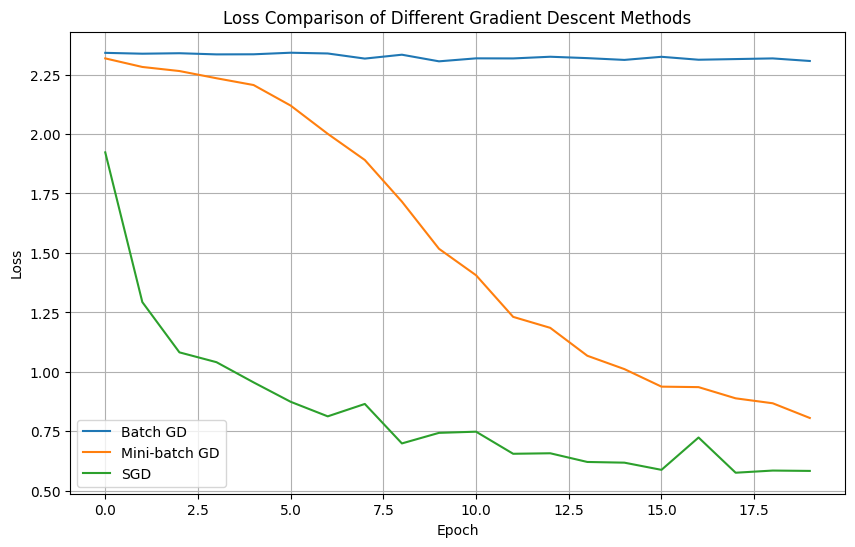

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(batch_losses, label='Batch GD')
plt.plot(minibatch_losses, label='Mini-batch GD')
plt.plot(sgd_losses, label='SGD')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison of Different Gradient Descent Methods')
plt.legend()
plt.grid(True)
plt.show()

Graph compares loss of 3 gradient descent methods over epochs
- Batch GD has highest initial loss, converges slowly
- Mini-batch GD and SGD start with lower loss, converge faster
- By epoch 17.5, SGD achieves lowest loss, followed by mini-batch GD, then batch GD